In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../"))

from desc import set_device
set_device("gpu")


import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.constants import mu_0
import plotly.graph_objects as go
import warnings

import desc
from desc.transform import Transform
from desc.equilibrium import EquilibriaFamily, Equilibrium
from desc.plotting import *
from desc.optimize import Optimizer
from desc.examples import get
from desc.objectives.getters import get_fixed_boundary_constraints, maybe_add_self_consistency
from desc.grid import LinearGrid, QuadratureGrid, Grid
from desc.profiles import PowerSeriesProfile

from desc.backend import jnp
from desc.compute import get_params, get_profiles, get_transforms
from desc.compute.utils import _compute as compute_fun
from desc.nestor import Nestor
from desc.objectives.objective_funs import _Objective
from desc.singularities import (
    DFTInterpolator,
    FFTInterpolator,
    virtual_casing_biot_savart,
    _nonsingular_part,
    _singular_part,
    kernels,
)
from desc.utils import Timer, errorif, warnif

from desc.objectives.normalization import compute_scaling_factors
from desc.coils import MixedCoilSet
from desc.magnetic_fields import field_line_integrate

/home/yigit/Codes/DESC/desc/__init__.py:98: UserWarning: No GPU found, falling back to CPU
  warnings.warn(colored("No GPU found, falling back to CPU", "yellow"))


DESC version 0.12.1+7.g2ea24b4f1.dirty,using JAX backend, jax version=0.4.31, jaxlib version=0.4.31, dtype=float64
Using device: CPU, with 5.52 GB available memory


In [2]:
coils = MixedCoilSet.from_makegrid_coilfile("Giuliani.is.free.0403.3.00050.coils")

In [3]:
eq = get("ARIES-CS")
eq

Equilibrium at 0x7569b7abfe60 (L=24, M=12, N=8, NFP=3, sym=1, spectral_indexing=fringe)

In [4]:
nturns = 100  # how many turns
nplanes = 6  # how many places within 1 field period do we want output

rho=0.52
# for starting locations we'll pick positions on flux surfaces on the outboard midplane
# grid = LinearGrid(rho=np.linspace(0.52,0.6,15))
# grid = LinearGrid(rho=np.array([0.52,0.56]), theta=np.pi)
grid = LinearGrid(rho=np.array([0.56]), theta=np.pi)

r0 = eq.compute("R", grid=grid)["R"]
z0 = eq.compute("Z", grid=grid)["Z"]
phis = (
    np.linspace(0, 2 * np.pi / eq.NFP, nplanes, endpoint=False)
    + np.arange(0, nturns)[:, None] * 2 * np.pi / eq.NFP
).flatten()

In [6]:
import time
t0=time.time()

rs, zs = field_line_integrate(r0, z0, phis, eq, grid=grid)
print(f"took {time.time()-t0} seconds")

TracerArrayConversionError: The numpy.ndarray conversion method __array__() was called on traced array with shape float64[1]
The error occurred while tracing the function odefun at /home/yigit/Codes/DESC/desc/magnetic_fields/_core.py:1605 for jit. This value became a tracer due to JAX operations on these lines:

  operation a[35m:f64[1][39m = pjit[
  name=_take
  jaxpr={ [34m[22m[1mlambda [39m[22m[22m; b[35m:f64[1][39m c[35m:i64[1][39m. [34m[22m[1mlet
      [39m[22m[22md[35m:bool[1][39m = lt c 0
      e[35m:i64[1][39m = add c 1
      f[35m:i64[1][39m = pjit[
        name=_where
        jaxpr={ [34m[22m[1mlambda [39m[22m[22m; g[35m:bool[1][39m h[35m:i64[1][39m i[35m:i64[1][39m. [34m[22m[1mlet
            [39m[22m[22mj[35m:i64[1][39m = select_n g i h
          [34m[22m[1min [39m[22m[22m(j,) }
      ] d e c
      k[35m:i64[1,1][39m = broadcast_in_dim[broadcast_dimensions=(0,) shape=(1, 1)] f
      l[35m:f64[1][39m = gather[
        dimension_numbers=GatherDimensionNumbers(offset_dims=(), collapsed_slice_dims=(0,), start_index_map=(0,))
        fill_value=nan
        indices_are_sorted=False
        mode=GatherScatterMode.FILL_OR_DROP
        slice_sizes=(1,)
        unique_indices=True
      ] b k
    [34m[22m[1min [39m[22m[22m(l,) }
] m n
    from line /home/yigit/Codes/DESC/desc/grid.py:489:15 (_Grid.compress)
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerArrayConversionError

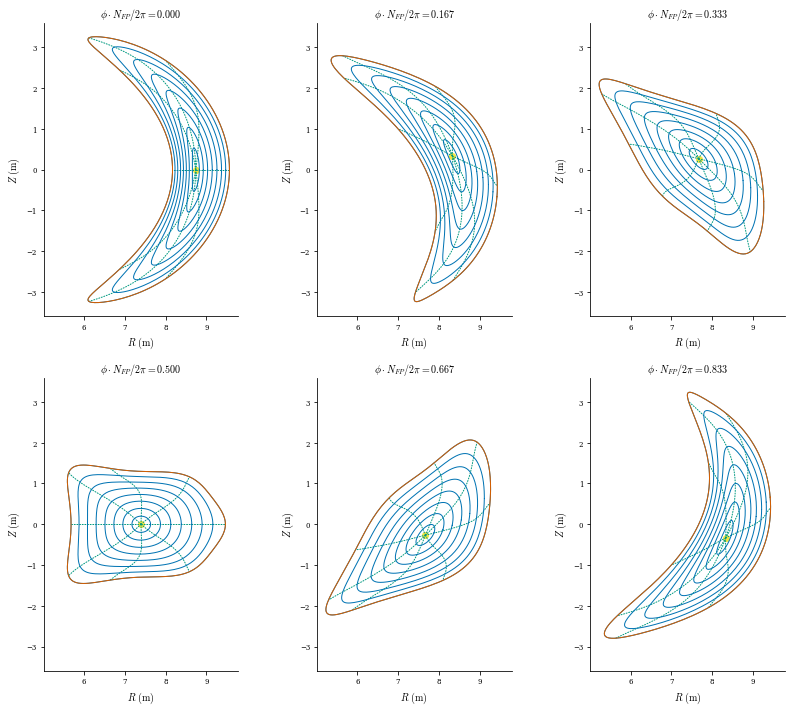

In [9]:
plot_surfaces(eq);

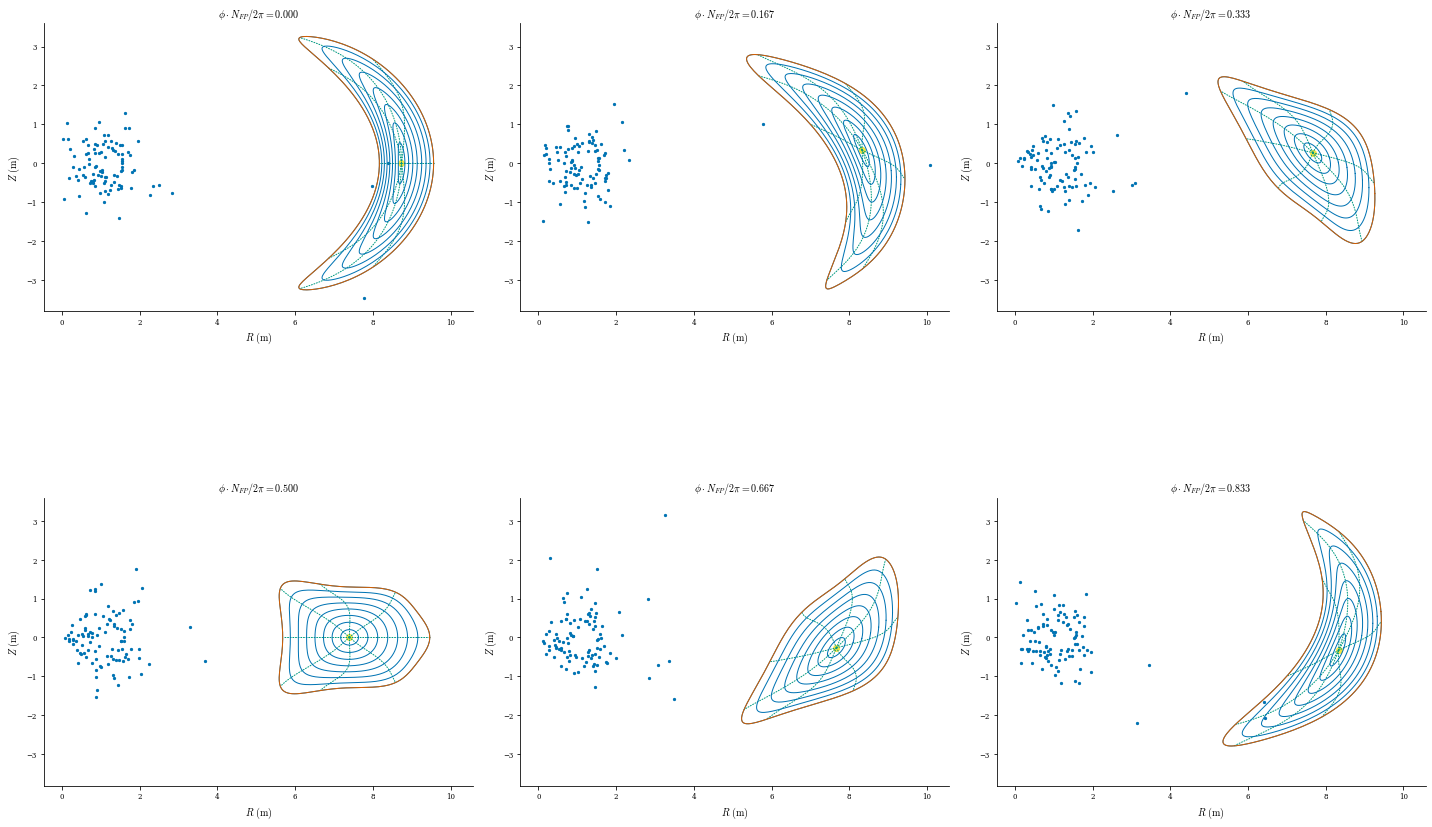

In [16]:
zs = zs.reshape((nturns, nplanes, -1))
rs = rs.reshape((nturns, nplanes, -1))

fig, ax = plot_surfaces(eq,figsize=(20,20))
ax = ax.flatten()
# for i in range(nplanes):
i=0
ax[i].scatter(rs[:, i, :], zs[:, i, :], s=5)
for i,j in zip([5,4,3,2,1],[1,2,3,4,5]):
    ax[i].scatter(rs[:, j, :], zs[:, j, :], s=5)